# Ethical Riemann Hypothesis: Basic Simulation

This notebook introduces the core concepts of the Ethical Riemann Hypothesis (ERH) and demonstrates basic simulations.

## Theory Overview

The ERH draws an analogy between:
- **Prime numbers** ↔ **Ethical primes** (critical misjudgments)
- **π(x)** (prime counting) ↔ **Π(x)** (ethical prime counting)
- **Li(x)** (logarithmic integral) ↔ **B(x)** (baseline expectation)
- **E(x) = π(x) - Li(x)** ↔ **E(x) = Π(x) - B(x)**

**Ethical Riemann Hypothesis**: |E(x)| ≤ C·x^(1/2 + ε)

This means errors in moral judgment grow at most like √x, indicating a "healthy" system.

## Setup and Imports

In [1]:
import sys
import os
from pathlib import Path

# Robust path resolution for notebooks in Binder/cloud/local
def setup_paths():
    """Add simulation directory to Python path, works in all environments"""
    # Try multiple strategies
    current_dir = Path(os.getcwd())
    
    # Strategy 1: If in notebooks/, go up one level
    if current_dir.name == 'notebooks':
        simulation_dir = str(current_dir.parent)
        if simulation_dir not in sys.path:
            sys.path.insert(0, simulation_dir)
        return simulation_dir
    
    # Strategy 2: If in simulation/, use current
    if current_dir.name == 'simulation':
        simulation_dir = str(current_dir)
        if simulation_dir not in sys.path:
            sys.path.insert(0, simulation_dir)
        return simulation_dir
    
    # Strategy 3: Look for simulation directory
    for parent in current_dir.parents:
        if parent.name == 'simulation':
            simulation_dir = str(parent)
            if simulation_dir not in sys.path:
                sys.path.insert(0, simulation_dir)
            return simulation_dir
    
    # Strategy 4: Try relative path
    simulation_dir = os.path.join(os.getcwd(), 'simulation')
    if os.path.exists(simulation_dir):
        if simulation_dir not in sys.path:
            sys.path.insert(0, simulation_dir)
        return simulation_dir
    
    # Fallback: add common paths
    for path in ['..', '../simulation', 'simulation']:
        abs_path = os.path.abspath(path)
        if abs_path not in sys.path:
            sys.path.insert(0, abs_path)
    
    return None

simulation_dir = setup_paths()
print(f"Simulation directory: {simulation_dir or 'Using fallback paths'}")
print(f"Current working directory: {os.getcwd()}")

import numpy as np
import matplotlib.pyplot as plt

# Verify imports work
try:
    from core.action_space import generate_world, get_action_statistics
    from core.judgement_system import BiasedJudge, evaluate_judgement
    from core.ethical_primes import select_ethical_primes, compute_Pi_and_error, analyze_error_growth
    from visualization.plots import setup_paper_style, plot_Pi_B_E, plot_error_growth
    print("[OK] All imports successful!")
except ImportError as e:
    print(f"[ERROR] Import failed: {e}")
    print("\nTroubleshooting:")
    print("1. Make sure you're running from the notebooks directory")
    print("2. Check that simulation/ directory exists")
    print("3. Verify all dependencies are installed: pip install -r requirements.txt")
    raise

setup_paper_style()
np.random.seed(42)

print("Setup complete!")


Simulation directory: D:\GitHub\Ethic-Latex\simulation
Current working directory: D:\GitHub\Ethic-Latex\simulation\notebooks
[OK] All imports successful!
Setup complete!


## Generate Moral Action Space

We start by generating a world of moral actions with varying complexities and true moral values.


In [2]:
# Generate a world of moral actions
num_actions = 1000
actions = generate_world(
    num_actions=num_actions,
    complexity_dist='zipf',  # Zipf distribution for complexity (few high, many low)
    random_seed=42
)

# Display statistics
stats = get_action_statistics(actions)
print(f"Generated {num_actions} actions")
print(f"Complexity range: [{min(a.c for a in actions)}, {max(a.c for a in actions)}]")
print(f"True moral value range: [{min(a.V for a in actions):.2f}, {max(a.V for a in actions):.2f}]")
print(f"Average importance: {np.mean([a.w for a in actions]):.3f}")


Generated 1000 actions
Complexity range: [1, 100]
True moral value range: [-1.00, 1.00]
Average importance: 2.026


## Apply Judgment System

We create a biased judge that systematically overestimates moral values, with the bias increasing with complexity.


In [3]:
# Create a biased judge
judge = BiasedJudge(bias_strength=0.2, noise_scale=0.1)
print(f"Judge type: {type(judge).__name__}")
print(f"Bias strength: {judge.bias_strength}")
print(f"Noise scale: {judge.noise_scale}")

# Evaluate all actions
tau = 0.3  # Error threshold
evaluate_judgement(actions, judge, tau=tau)

# Count mistakes
mistakes = sum(1 for a in actions if a.mistake_flag == 1)
print(f"\nMistakes detected: {mistakes} out of {num_actions} ({mistakes/num_actions:.1%})")
print(f"Average absolute error: {np.mean([abs(a.delta) for a in actions if a.delta is not None]):.3f}")


Judge type: BiasedJudge
Bias strength: 0.2
Noise scale: 0.1

Mistakes detected: 129 out of 1000 (12.9%)
Average absolute error: 0.178


## Identify Ethical Primes

Ethical primes are critical misjudgments - actions where the judge made a significant error on an important decision.


In [4]:
# Select ethical primes (critical misjudgments)
primes = select_ethical_primes(actions, importance_quantile=0.9)
print(f"Found {len(primes)} ethical primes")
print(f"These represent {len(primes)/num_actions:.1%} of all actions")

if len(primes) > 0:
    print(f"\nEthical prime characteristics:")
    print(f"  Average complexity: {np.mean([p.c for p in primes]):.2f}")
    print(f"  Average importance: {np.mean([p.w for p in primes]):.3f}")
    print(f"  Average error: {np.mean([abs(p.delta) for p in primes if p.delta is not None]):.3f}")


Found 11 ethical primes
These represent 1.1% of all actions

Ethical prime characteristics:
  Average complexity: 2.09
  Average importance: 5.029
  Average error: 0.351


## Compute Distribution Functions

We compute:
- **Π(x)**: Count of ethical primes up to complexity x
- **B(x)**: Baseline expectation (analogous to Li(x) in number theory)
- **E(x) = Π(x) - B(x)**: Error term


Computed distributions for x in [0, 100]

At x = 100:
  Π(100) = 11.0 (actual count)
  B(100) = 21.7 (expected)
  E(100) = -10.7 (error)


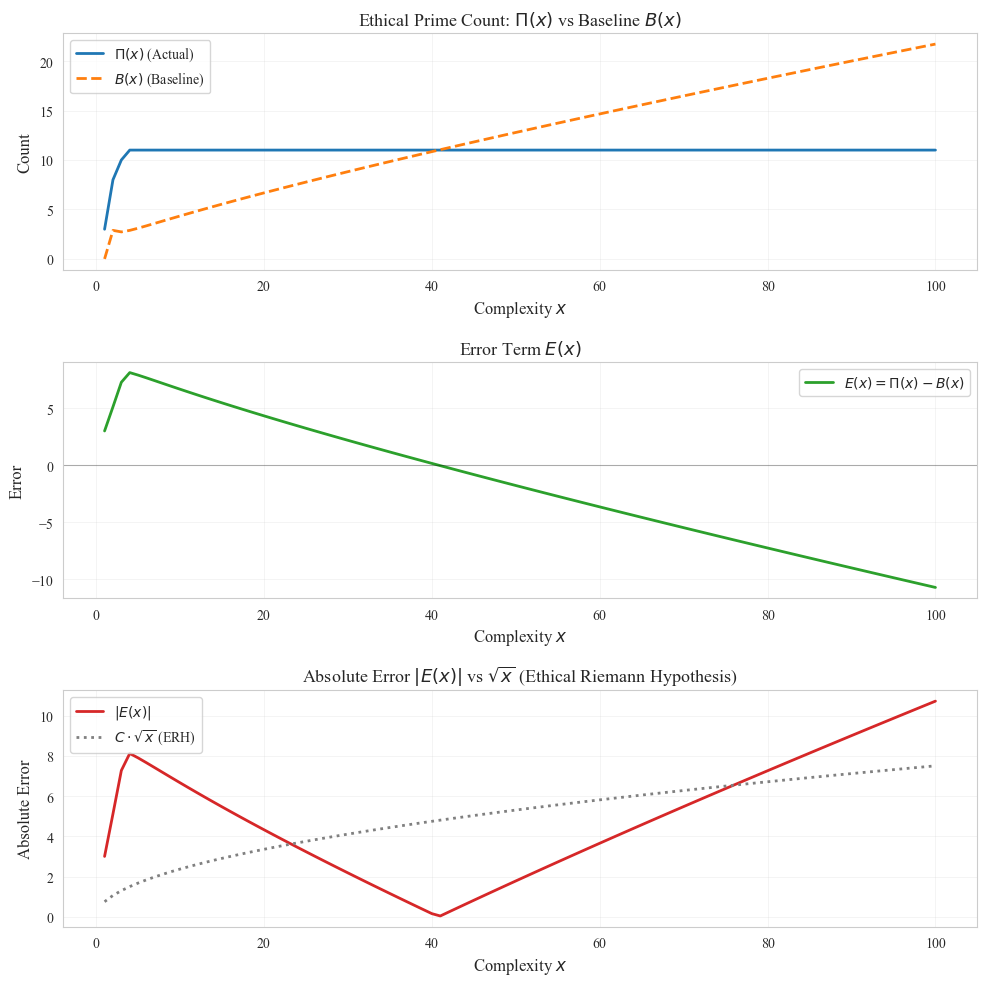

In [5]:
# Compute Pi(x), B(x), and E(x)
X_max = 100
Pi_x, B_x, E_x, x_vals = compute_Pi_and_error(primes, X_max=X_max)

print(f"Computed distributions for x in [0, {X_max}]")
print(f"\nAt x = {X_max}:")
print(f"  Π({X_max}) = {Pi_x[-1]:.1f} (actual count)")
print(f"  B({X_max}) = {B_x[-1]:.1f} (expected)")
print(f"  E({X_max}) = {E_x[-1]:.1f} (error)")

# Plot the distributions
plot_Pi_B_E(x_vals, Pi_x, B_x, E_x, save_path='../output/figures/01_pi_b_e.pdf')
plt.show()


## Analyze Error Growth

The Ethical Riemann Hypothesis (ERH) states that |E(x)| should grow at most like √x. We test this by fitting |E(x)| ≈ C·x^α and checking if α ≤ 0.5.


Error Growth Analysis:
Estimated exponent α: 0.0487
Expected (ERH): α ≤ 0.500
ERH satisfied: False
Growth rate: sublinear_slow
R² (fit quality): 0.0017
Constant C: 3.0291


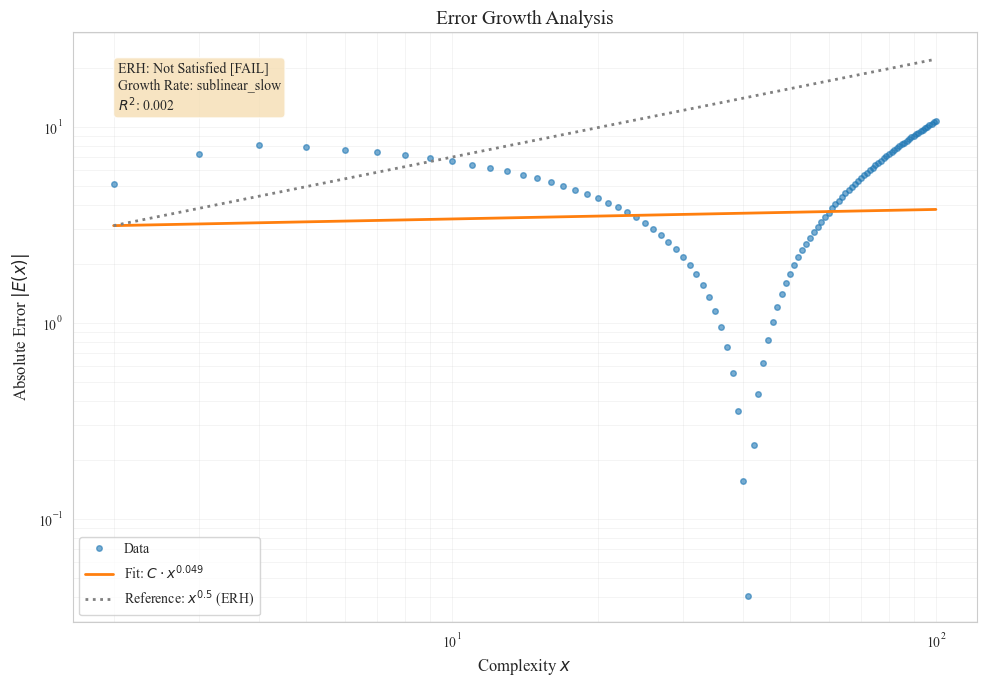

In [6]:
# Analyze error growth
analysis = analyze_error_growth(E_x, x_vals)

print("Error Growth Analysis:")
print("=" * 60)
print(f"Estimated exponent α: {analysis.get('estimated_exponent', 'N/A'):.4f}")
print(f"Expected (ERH): α ≤ 0.500")
print(f"ERH satisfied: {analysis.get('erh_satisfied', False)}")
print(f"Growth rate: {analysis.get('growth_rate', 'N/A')}")
print(f"R² (fit quality): {analysis.get('r_squared', 0):.4f}")

if 'constant_C' in analysis:
    print(f"Constant C: {analysis['constant_C']:.4f}")

# Plot error growth
plot_error_growth(x_vals, E_x, analysis, save_path='../output/figures/01_error_growth.pdf')
plt.show()


## Summary Statistics

Overall performance metrics for this judgment system.


In [7]:
# Display comprehensive statistics
stats = get_action_statistics(actions)
print("Action Statistics:")
print("=" * 60)
print(f"Total actions: {stats['num_actions']}")

if 'mistakes' in stats:
    print(f"Mistakes: {stats['mistakes']['count']} ({stats['mistakes']['rate']:.1%})")
    
if 'error' in stats:
    print(f"\nError metrics:")
    print(f"  MAE (Mean Absolute Error): {stats['error']['mae']:.4f}")
    print(f"  RMSE (Root Mean Squared Error): {stats['error']['rmse']:.4f}")
    if 'max' in stats['error']:
        print(f"  Max error: {stats['error']['max']:.4f}")

print(f"\nComplexity distribution:")
print(f"  Mean: {stats['complexity']['mean']:.2f}")
print(f"  Std: {stats['complexity']['std']:.2f}")

print(f"\nMoral value distribution:")
print(f"  Mean: {stats['moral_value']['mean']:.3f}")
print(f"  Std: {stats['moral_value']['std']:.3f}")

# Interpretation
print("\n" + "=" * 60)
print("Interpretation:")
if analysis.get('erh_satisfied', False):
    print("✓ ERH is SATISFIED - This judgment system is 'Riemann-healthy'")
    print("  Errors grow at most like √x, indicating bounded uncertainty.")
else:
    alpha = analysis.get('estimated_exponent', 0)
    if alpha < 0.5:
        print("✓ Better than ERH - Errors grow slower than √x")
        print("  This is excellent - very robust system.")
    elif alpha < 1.0:
        print("⚠ ERH NOT satisfied - Errors grow faster than √x")
        print(f"  Exponent α = {alpha:.3f} suggests suboptimal but manageable growth.")
    else:
        print("✗ ERH VIOLATED - Errors grow linearly or worse")
        print(f"  Exponent α = {alpha:.3f} indicates systematic degradation.")


Action Statistics:
Total actions: 1000
Mistakes: 129 (12.9%)

Error metrics:
  MAE (Mean Absolute Error): 0.1783
  RMSE (Root Mean Squared Error): 0.2053

Complexity distribution:
  Mean: 4.00
  Std: 11.38

Moral value distribution:
  Mean: -0.001
  Std: 0.705

Interpretation:
✓ Better than ERH - Errors grow slower than √x
  This is excellent - very robust system.
